In [20]:
from datetime import datetime, timedelta

import ccxt
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('V5/models/V5-model.h5', compile=False)
model.compile(optimizer='adam', loss='mean_squared_error')

# Load the model weights
model.load_weights('V5/models/V5-weights.h5')

# Load the scaler
scaler = joblib.load('V5/models/V5-scaler.joblib')

In [21]:
from datetime import datetime, timedelta

import ccxt
import numpy as np
import yfinance as yf

In [22]:
timeframe = '1m'
symbol = 'BTC/USDT'
minutes = 60 
since = datetime.now() - timedelta(minutes=minutes)
since = int(since.timestamp() * 1000)
limit = minutes+1
show_more_graph = False

In [23]:
# downloade the data with yfinance, get the last 2 hours
# last_60_minutes = yf.download(tickers='BTC-USD', period='7d', interval='1m')
# use ccxt to get the last 2 hours
exchange = ccxt.binance()
last_60_minutes = exchange.fetch_ohlcv('BTC/USDT', timeframe=timeframe, since=since, limit=limit)
last_60_minutes = pd.DataFrame(last_60_minutes, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
last_60_minutes['Timestamp'] = pd.to_datetime(last_60_minutes['Timestamp'], unit='ms')
last_60_minutes.set_index('Timestamp', inplace=True)
last_60_minutes.index = last_60_minutes.index + pd.DateOffset(hours=2)


In [24]:
# 2. Scale the data to be values between 0 and 1
last_60_minutes_scaled = scaler.fit_transform(last_60_minutes[["Close"]])
# 3. Reshape the data into the shape accepted by the LSTM model
last_60_minutes_scaled = np.reshape(last_60_minutes_scaled, (1, last_60_minutes_scaled.shape[0], 1)) # cannot reshape array of size 60 into shape (1,1,1)
# 4. Make predictions using the LSTM model
pred = model.predict(last_60_minutes_scaled)
pred = scaler.inverse_transform(pred)

ValueError: in user code:

    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\MrBios\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_2" "                 f"(type Sequential).
    
    Input 0 of layer "lstm_6" is incompatible with the layer: expected shape=(None, None, 9), found shape=(None, 60, 1)
    
    Call arguments received by layer "sequential_2" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 60, 1), dtype=float32)
      • training=False
      • mask=None


: 

In [ ]:
pred.mean()
pred_time = pd.date_range(start=last_60_minutes.index[-1], periods=len(pred[0]) + 1, freq='1min')

NameError: name 'pred' is not defined

In [ ]:
# at what time will the price be at the predicted price
print("The Bitcoin price will be at {} at {}.".format(pred[0][-1], pred_time[-1]))
# add a what time the prediction started
print("The prediction started at {}.".format(pred_time[0]))
print("The Bitcoin price was at {} at {}.".format(last_60_minutes["Close"].iloc[-1], last_60_minutes.index[-1]))

The Bitcoin price will be at 28080.201171875 at 2023-06-20 21:28:00.
The prediction started at 2023-06-20 21:18:00.
The Bitcoin price was at 27892.17 at 2023-06-20 21:18:00.


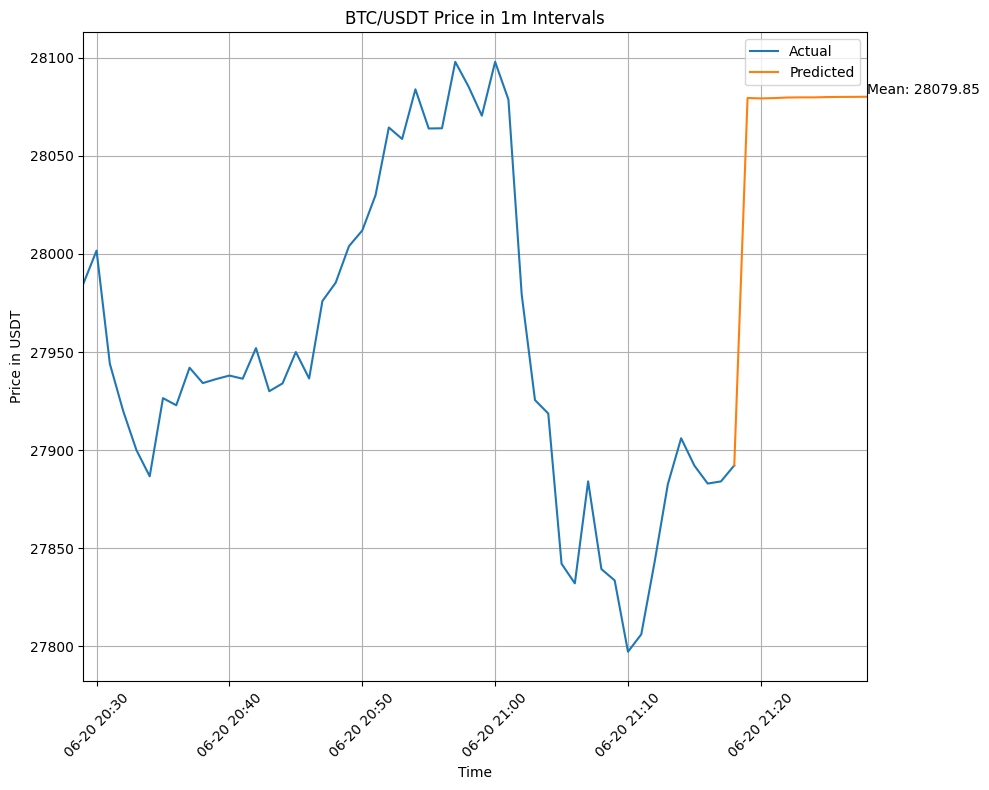

In [ ]:
import matplotlib.dates as mdates

# Create a single subplot for both actual and predicted values
fig, ax = plt.subplots(figsize=(10, 8))

last_amount_of_points = -50
# Plot the actual values for the last 100 data points
ax.plot(last_60_minutes.index[last_amount_of_points:], last_60_minutes["Close"].tail(last_amount_of_points * -1), label='Actual')
ax.grid(True)
ax.set_title(f'{symbol} Price in {timeframe} Intervals')
ax.set_xlabel('Time')
pair = symbol.split('/')
ax.set_ylabel('Price in ' + pair[1])

# Plot all the predicted values
pred_time = pd.date_range(start=last_60_minutes.index[-1], periods=len(pred[0]) + 1, freq='1min')
pred_values = np.concatenate(([last_60_minutes["Close"].iloc[-1]], pred[0]))
ax.plot(pred_time, pred_values, label='Predicted')

# Format the tick labels to display numbers in regular format
ax.get_yaxis().get_major_formatter().set_useOffset(False)

# Set the x-axis limits to show both actual and predicted values
ax.set_xlim(last_60_minutes.index[last_amount_of_points], pred_time[-1])

# Format the tick labels with additional minutes information
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M'))
# Rotate the x-axis tick labels
ax.xaxis.set_tick_params(rotation=45)

# Display the mean value of pred
mean_pred = pred.mean()
ax.text(pred_time[-1], mean_pred, f"Mean: {mean_pred:.2f}", verticalalignment='bottom')

# Display the legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
